In [19]:
##########################################################
# Written in Jupyter Notebook 4.4.1
# with Python 2.7.11
# installed via Anaconda version 1.9.12 (conda 4.8.3)
# run on macOS High Sierra (10.13.6)
#
# Jupyter Notebook required to downgrade tornado to 4.5.3
##########################################################

import numpy as np # numpy version 1.15.4

import sys 
sys.path.append('./SphericalHarmonics/')
import SH_library

import matplotlib.pyplot as plt # matplotlib version 2.2.5
from mpl_toolkits.basemap import Basemap # Basemap version 1.3.0

In [20]:
##############################################
# Useful definitions
##############################################

# define coordinates of Sulmona basin location
colat_SUL = 47.8488
lon_SUL   = 13.8229 

# define the lon/lat grid
lons_grid = np.linspace(-np.pi,np.pi,num=100)
lats_grid = np.linspace(np.pi/2,-np.pi/2,num=100)

LONS, LATS = np.meshgrid(lons_grid, lats_grid)
THETA = -LATS + np.pi/2

# define Earth surface and CMB radii
r_a = 6371.0     # Earth's surface
r_c = 3485.0     # CMB

# define some quantities for maps (useful to define them once if plotting multiple maps)
map1 = Basemap(projection='moll',lat_0=0,lon_0=0,resolution='l')
nlevels = 41   # number of contours in colormaps
SS = 600       # size of the star in the maps

# define the background magnetic field model (same model used for the optimisation code)
MODEL = 'CHAOS-6-x9_core_2019.0007.dat'

In [21]:
###########################################################
# Calculate the background magnetic field in physical space
###########################################################

# load the Gauss coefficients
coeffs_MF = np.loadtxt(MODEL,skiprows=1)

# calculate magnetic field components at the CMB, on the grid defined in the cell above
# Note: the CHAOS model loaded here provides coefficients up to l = 20, which might be 
# contaminated by external contributions. We only consider coefficients up to l = 13 (as
# in the optimal flow calculation)
Br_c, Bt_c, Bp_c = SH_library.calcB(coeffs_MF[0:104,:],THETA,LONS,r_a,r_c)

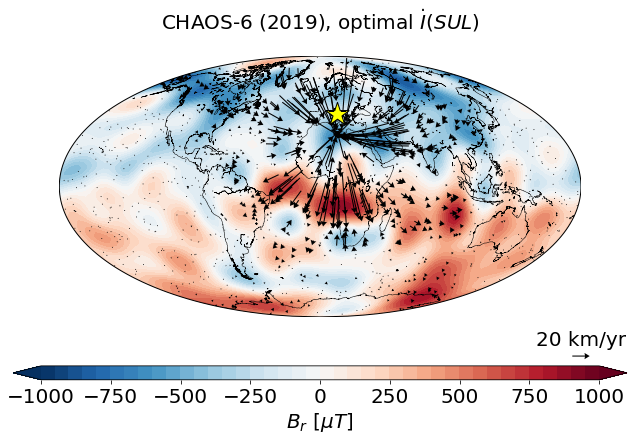

In [22]:
############################################################
# Plot optimal flow and background magnetic field at the CMB
############################################################

plt.figure(figsize=(11,6))

# draw coastlines, country boundaries, fill continents.
map1.drawcoastlines(linewidth=0.50)

# map the lon/lat grid
xs, ys = map1(LONS*180./np.pi, LATS*180./np.pi)

# load the optimal flow
X,Y,U,V = np.loadtxt('./FLOW_VECTORS_RANDOM.DAT',unpack=True)    
long = X
lat = Y
    
# rescale the radial magnetic field at the CMB    
Zs = Br_c/1000.
Zmax = 1000
Zmin = -Zmax


#####################
# colormap 
bounds = np.linspace(Zmin,Zmax,11)
cs = map1.contourf(xs,ys,Zs,cmap='RdBu_r', 
                   levels=np.linspace(-Zmax,Zmax,nlevels)
                   , extend = 'both'
                   )

clb = plt.colorbar(cs
                   ,fraction=0.05
                   ,orientation='horizontal'
                   ,aspect = 40
                   )
clb.set_label(r'$B_r \ [\mu T]$'
                     , fontsize = 20)
clb.ax.tick_params(labelsize=20)

#####################
# quiver of the flow
uproj,vproj,xx,yy = \
map1.rotate_vector(np.array(V),-np.array(U),np.array(long),np.array(lat),returnxy=True)

for i in range(0,len(xx)):
    Q = map1.quiver(xx[i],yy[i],uproj[i],vproj[i],angles='uv',pivot='mid',scale=600,width=0.002,headwidth=6)

plt.quiverkey(Q
              ,1,-0.15 # original pos = 0.5,-0.2
              , 20,'20 km/yr',coordinates='axes'
              , fontproperties={'size': 20})

####################
# station (SUL) location
xS, yS = map1(lon_SUL, 90-colat_SUL)
map1.scatter(xS,yS,s=SS,edgecolor='k',color='yellow',alpha=1,marker='*'
             , zorder=100
             )

####################
# title
plt.title(r'CHAOS-6 (2019), optimal $\dot{I}(SUL)$', y=1.08, fontsize = 20)

plt.show()